In [2]:
import sys
from pathlib import Path

# Add repo root to sys.path FIRST so local trace package takes precedence
repo_root = Path("/Users/rjm707/Desktop/trace_paper")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Now import from local trace package
from trace.statistics import logit, inv_logit
import polars as pl

In [3]:
df = pl.read_csv("data/semaglutide-atc_table.csv").with_columns(
    group=pl.col("outcome").str.head(1)
)
df

outcome,rd,rel_rd,outcome_untreated,Untreated_prevalence,outcome_treated,treated_prevalence,log_RR,group
str,f64,f64,f64,f64,f64,f64,f64,str
"""A01AA""",0.010272,0.443116,4816.4,0.019505,285.2,0.033467,0.539887,"""A"""
"""A01AB""",0.002102,0.19373,2194.4,0.008887,110.4,0.012955,0.376924,"""A"""
"""A01AD""",0.001503,0.531769,595.9,0.002413,36.8,0.004318,0.581903,"""A"""
"""A02AA""",0.018311,0.407116,9479.1,0.038387,539.4,0.063296,0.500091,"""A"""
"""A02AD""",0.001874,0.333326,1126.7,0.004563,63.4,0.00744,0.488894,"""A"""
…,…,…,…,…,…,…,…,…
"""V03AF""",-0.001435,-0.642826,471.0,0.001907,6.9,0.00081,-0.856859,"""V"""
"""V04CX""",0.000162,0.046646,855.5,0.003465,31.0,0.003638,0.048779,"""V"""
"""V07AB""",-0.001734,-0.276002,1270.9,0.005147,38.9,0.004565,-0.120008,"""V"""


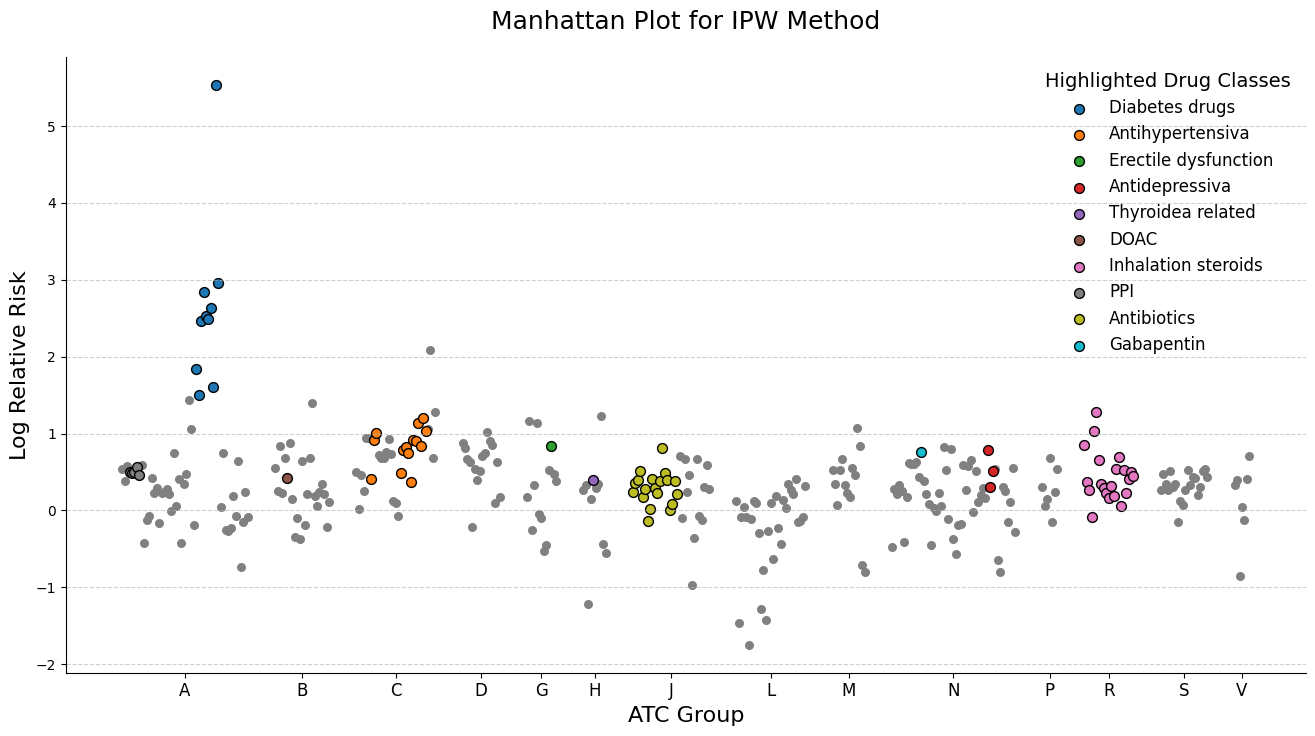

In [4]:
import matplotlib.pyplot as plt

method_df = df.sort('group', 'outcome')
method_df = method_df.with_columns(
    ind=pl.row_index().cast(pl.Int64)
)
method_df = method_df.with_columns(
    plot_idx = pl.col("ind") + (pl.col("group").rank("dense") - 1) * 10
)

# 3. Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# # Get group-based information for coloring and x-axis labeling
# groups = method_df.group_by('group')
groups = method_df['group'].unique(maintain_order=True).to_list()

# # Using a colormap for distinct colors per group
# colors = plt.cm.get_cmap('tab10', len(groups))
colors = plt.colormaps["tab10"]
color_map = {group: colors(i) for i, (group) in enumerate(groups)}

group_centers = []

# Plot each group with a different color
for i, (group_name) in enumerate(groups):
    color = color_map[group_name]
    group_df = method_df.filter(pl.col('group') == group_name)
    x = group_df['plot_idx']#+(i*20)
    ax.scatter(x, group_df['log_RR'], color="gray", s=30)
    group_centers.append(x.median())
    # ax.vlines(x=x.max()+5, ymin=-2, ymax=15, color='black', linestyle='--', alpha=0.5)

# Customize the plot
special_atc = [["A10"], ["C02", "C07", "C08", "C09"], ["G04BE"], ["N06A"], ["H03AA"], ["B01AF"], ["R0"], ["A02"], ["J01", "P01AB01"], ["N02BF"]]
legend = ["Diabetes drugs", "Antihypertensiva", "Erectile dysfunction", "Antidepressiva", "Thyroidea related", "DOAC", "Inhalation steroids", "PPI", "Antibiotics", "Gabapentin"]
for atc, leg in zip(special_atc, legend):
    atc_df = method_df.filter(
        pl.any_horizontal(pl.col('outcome').str.starts_with(code) for code in atc))
    ax.scatter(atc_df['plot_idx'], atc_df['log_RR'], s=50, edgecolor='black', label=leg)
ax.legend(title='Highlighted Drug Classes', fontsize=12, title_fontsize=14, loc='upper right', frameon=False)


ax.set_xticks(group_centers)
ax.set_xticklabels(sorted(method_df['group'].unique()), fontsize=12)
ax.tick_params(axis='x', rotation=0)
# ax.set_ylim(bottom=-1,top=2)
# ax.set_yscale("log")

ax.set_xlabel('ATC Group', fontsize=16)
ax.set_ylabel('Log Relative Risk', fontsize=16)
ax.set_title(f'Manhattan Plot for IPW Method', fontsize=18, pad=20)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Potentially swap axes?

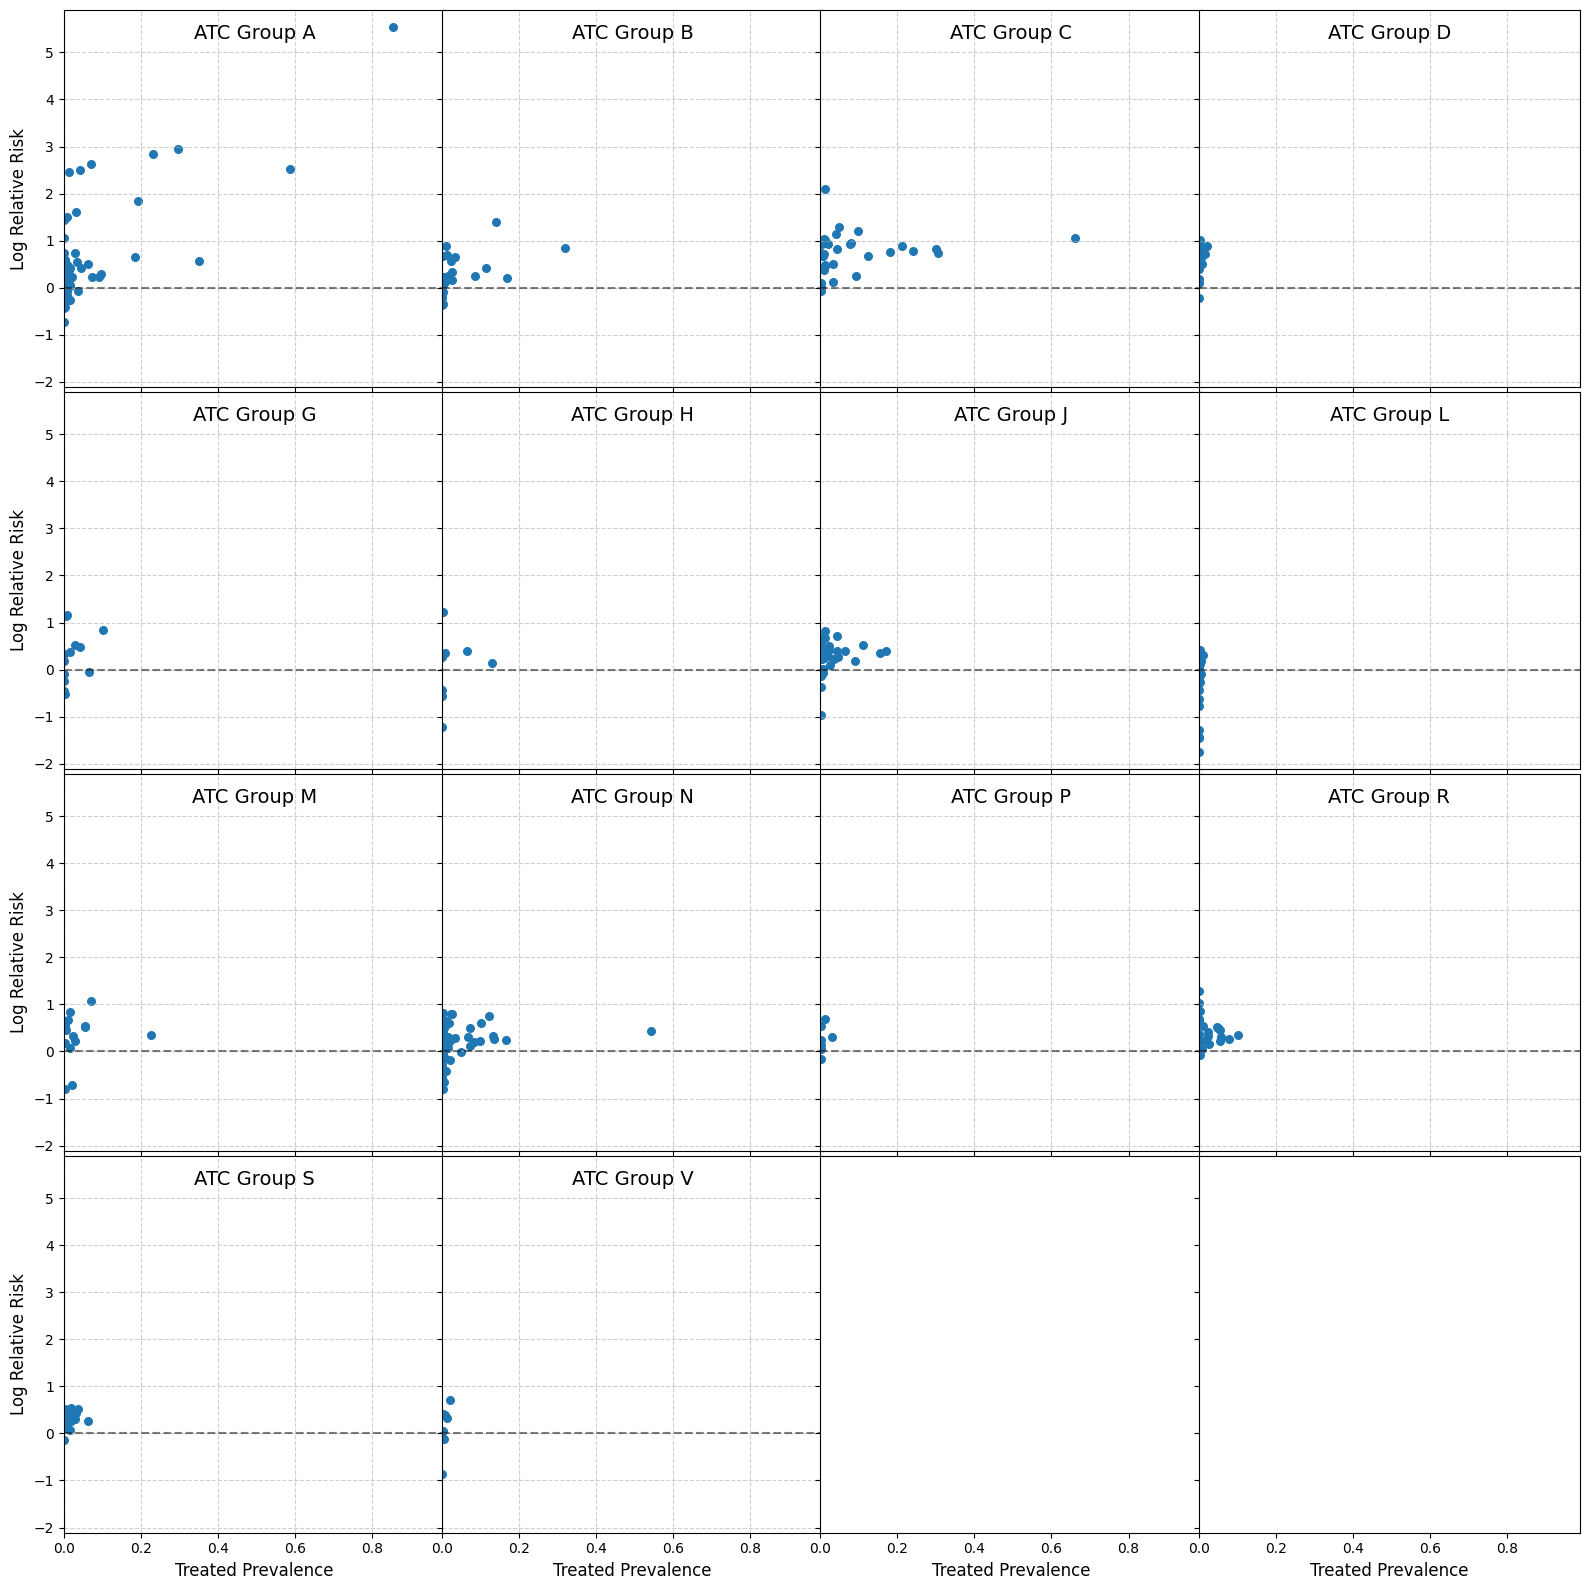

In [27]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
axs = axs.flatten()

for i, (group_name) in enumerate(groups):
    color = color_map[group_name]
    group_df = method_df.filter(pl.col('group') == group_name)
    x = group_df['treated_prevalence']
    axs[i].scatter(x, group_df['log_RR'], s=30)
    axs[i].set_title(f'ATC Group {group_name}', fontsize=14, y=0.9)
    axs[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)
    axs[i].grid(axis='x', linestyle='--', alpha=0.6)
    axs[i].set_xlim(0, 0.99)
    axs[i].set_xticks([])

for i in range(0, len(groups), 4):
    axs[i].set_ylabel('Log Relative Risk', fontsize=12)
for i in range(12, 16):
    axs[i].set_xlabel('Treated Prevalence', fontsize=12)
    axs[i].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8])

fig.tight_layout(h_pad=0, w_pad=-1)